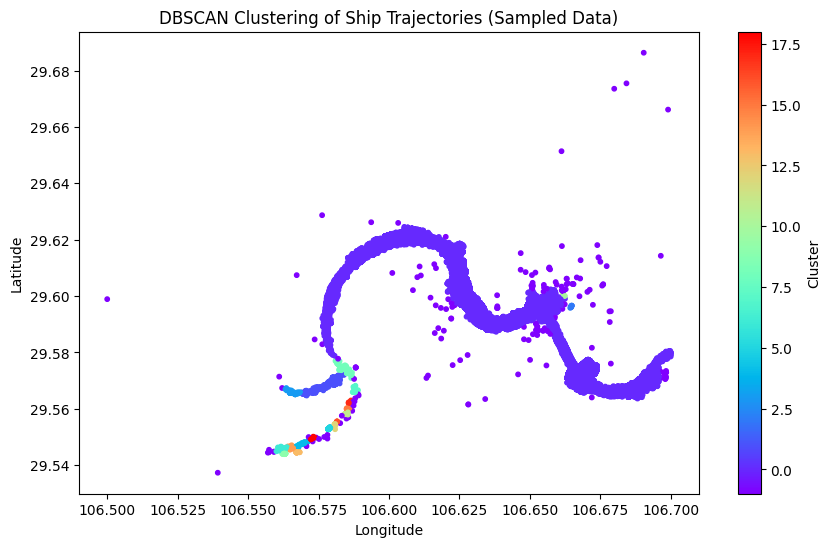

Sampled and clustered data saved to: C:\Projects\PycharmProjects\inland-ship-predict\scripts\..\output\dbscan_clustered_sampled_data.pkl


In [1]:
# Import the necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Step 1: Load the dataset from the pickle file
current_dir = os.getcwd()
data_path = os.path.join(current_dir, '..', 'output')

# Load data
filtered_data = pd.read_pickle(data_path + '/segmented_data.pkl')

# Step 2: Data Preprocessing (selecting relevant columns for clustering)
# For DBSCAN, we will cluster based on longitude and latitude
# Ensure no missing or invalid values in the selected columns
filtered_data = filtered_data[['longitude', 'latitude', 'segment_id']]

# Select a subset of the data (for example, 10% of the data or based on specific conditions)
# Here we use the sample() function to randomly select 10% of the data
sampled_data = filtered_data.sample(frac=0.03, random_state=42)  # Adjust frac to control the proportion of data

# Optionally, you can also filter by a specific condition, for example:
# sampled_data = filtered_data[filtered_data['segment_id'] == 1]

# Step 3: Applying DBSCAN clustering on the subset of data
dbscan = DBSCAN(eps=0.001, min_samples=5)  # You can adjust eps and min_samples based on your data

# Fit the model to the sampled data
sampled_data['cluster'] = dbscan.fit_predict(sampled_data[['longitude', 'latitude']])

# Step 4: Visualize the clustering result
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
plt.scatter(sampled_data['longitude'], sampled_data['latitude'], c=sampled_data['cluster'], cmap='rainbow', s=10)
plt.title('DBSCAN Clustering of Ship Trajectories (Sampled Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Step 5: Save the sampled and clustered data to a new pickle file
output_path = os.path.join(current_dir, '..', 'output', 'dbscan_clustered_sampled_data.pkl')
sampled_data.to_pickle(output_path)

print(f"Sampled and clustered data saved to: {output_path}")


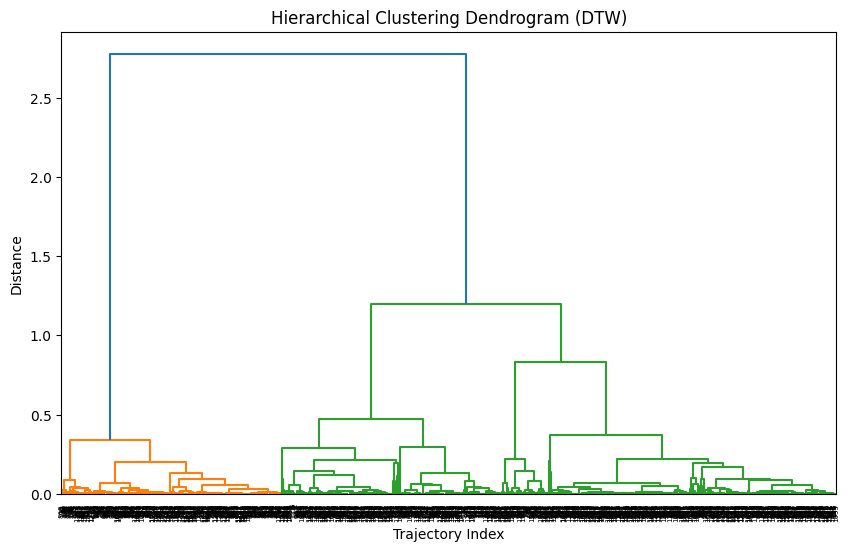

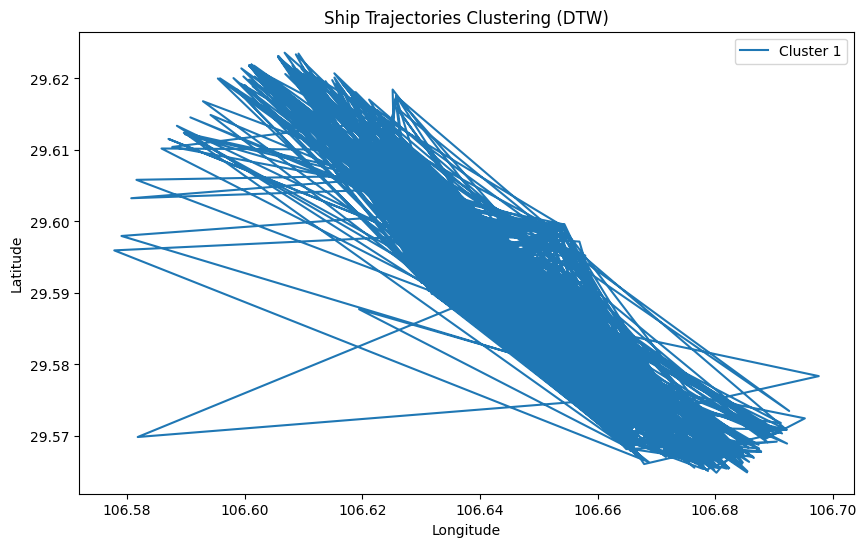

Sampled and clustered data saved to: C:\Projects\PycharmProjects\inland-ship-predict\scripts\..\output\dtw_clustered_sampled_data.pkl


In [5]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
from fastdtw import fastdtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Step 1: Load the dataset from the pickle file
current_dir = os.getcwd()
data_path = os.path.join(current_dir, '..', 'output')

# Load data
filtered_data = pd.read_pickle(data_path + '/segmented_data.pkl')

# Step 2: Select relevant columns and sample 10% of the data
filtered_data = filtered_data[['segment_id', 'longitude', 'latitude']]
sampled_data = filtered_data.sample(frac=0.0001, random_state=42)  # Adjust frac to control the proportion of data

# Group the data by segment_id to create individual trajectories
grouped_data = sampled_data.groupby('segment_id')

# Create a list of trajectories where each trajectory is a sequence of (longitude, latitude) points
trajectories = [group[['longitude', 'latitude']].values for _, group in grouped_data]

# Step 3: Calculate DTW distance matrix
n = len(trajectories)
distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        # Compute the DTW distance between trajectory i and trajectory j
        distance, _ = fastdtw(trajectories[i], trajectories[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

# Convert the distance matrix into a condensed form (required by linkage)
condensed_distance_matrix = squareform(distance_matrix)

# Step 4: Apply hierarchical clustering using the distance matrix
Z = linkage(condensed_distance_matrix, method='ward')

# Step 5: Plot the dendrogram to visualize the clustering result
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (DTW)')
plt.xlabel('Trajectory Index')
plt.ylabel('Distance')
plt.show()

# Step 6: Assign clusters based on a distance threshold
# Adjust the threshold to control the number of clusters
threshold = 500  # Adjust this based on your data
clusters = fcluster(Z, threshold, criterion='distance')

# Step 7: Add cluster labels back to the original data
# Map clusters to segment_id
cluster_labels = pd.DataFrame({'segment_id': grouped_data.groups.keys(), 'cluster': clusters})
sampled_data = sampled_data.merge(cluster_labels, on='segment_id')

# Step 8: Visualize the clustering result by coloring each trajectory with its cluster
plt.figure(figsize=(10, 6))
for cluster_id, cluster_data in sampled_data.groupby('cluster'):
    plt.plot(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster_id}')

plt.title('Ship Trajectories Clustering (DTW)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Step 9: Save the results to a new pickle file
output_path = os.path.join(current_dir, '..', 'output', 'dtw_clustered_sampled_data.pkl')
sampled_data.to_pickle(output_path)

print(f"Sampled and clustered data saved to: {output_path}")
